所需库

In [88]:
import numpy as np
from matplotlib import pyplot as plt

# 只使用了sklearn中的数据集load_iris
from sklearn.datasets import load_iris
# 使用sklearn中对训练结果和
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# 用于降维
from sklearn.decomposition import PCA

逻辑回归模型实现鸢尾花分类

In [89]:
class LogisticRegression:
    # 初始化学习率和迭代次数
    def __init__(self, learning_rate=0.01, iterations=1000, n_classes=3):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.n_classes = n_classes
        self.losses=[]
    # sigmoid函数
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
     # softmax函数
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    # fit函数 用于梯度下降求解w和b
    def fit(self, X, y):
        if self.n_classes==2:
            m, n = X.shape
            self.weights = np.zeros(n)
            self.bias = 0
            for _ in range(self.iterations):
                model = np.dot(X, self.weights) + self.bias
                
                prediction = self.sigmoid(model)
                
                dw = (1 / m) * np.dot(X.T, (prediction - y))
                db = (1 / m) * np.sum(prediction - y)
                
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
        #如果是多分类问题
        if self.n_classes>=3:
            m, n = X.shape
            self.weights = np.zeros((n, self.n_classes))
            self.bias = np.zeros(self.n_classes)
            # 将y转换为one-hot编码
            y_one_hot = np.eye(self.n_classes)[y]
            for _ in range(self.iterations):
                model = np.dot(X, self.weights) + self.bias
                prediction = self.softmax(model)
                
                loss = np.mean(np.square(prediction - y_one_hot))
                self.losses.append(loss)
                dw = (1 / m) * np.dot(X.T, (prediction - y_one_hot))
                db = (1 / m) * np.sum(prediction - y_one_hot, axis=0)
                
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
    
    # 预测函数 用于对测试样本进行预测
    def predict(self, X):
        """进行预测"""
        if self.n_classes==2:
            model = np.dot(X, self.weights) + self.bias
            prediction = self.sigmoid(model)
            return [1 if i > 0.5 else 0 for i in prediction]
        if self.n_classes>=3:
            model = np.dot(X, self.weights) + self.bias
            prediction = self.softmax(model)
            return np.argmax(prediction, axis=1)
    
    def accuracy_score(self,y_true, y_pred):
        """计算准确率"""
        correct_predictions = sum(y_pred[i] == y_true[i] for i in range(len(y_true)))
        accuracy = correct_predictions / len(y_true)
        return accuracy

    def coef_(self):
        """返回w"""
        return self.weights
    
    def intercept_(self):
        """返回b"""
        return self.bias
    
    def train_test_split(self,X, y, test_size=0.2, random_state=None):
        """将数据集划分为训练集和测试集"""
        if random_state:
            np.random.seed(random_state)
        
        # 随机打乱索引
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        
        # 根据test_size计算测试集大小
        test_set_size = int(X.shape[0] * test_size)
        
        # 划分测试集和训练集
        test_indices = indices[:test_set_size]
        train_indices = indices[test_set_size:]
        
        # 划分数据集
        X_train = X[train_indices]
        X_test = X[test_indices]
        y_train = y[train_indices]
        y_test = y[test_indices]
        
        return X_train, X_test, y_train, y_test 

决策树模型

In [90]:
'''决策树分类模型
    先定义树节点类DecisonNode,再定义决策树类DecisionTreeClassifier
    使用信息增益infomation gain,建立ID3算法
'''
class DecisionNode:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        # 对于决策节点
        self.feature_index = feature_index  #决策节点的特征的索引
        self.threshold = threshold          #决策节点的阈值
        self.left = left                    #决策节点的左孩子
        self.right = right                  #决策节点的右孩子
        self.info_gain = info_gain          #信息增益
        
        # 对于叶节点
        self.value = value                  #叶节点的值

class DecisionTreeClassifier:
    def __init__(self,min_samples_split=2, max_depth=2) -> None:
        # 初始化树的根节点
        self.root=None
        # 停止条件
        self.min_samples_split=min_samples_split    #最小分裂样本
        self.max_depth=max_depth                    #决策树最大深度

    '''
    训练模型
    X:样本数据中的变量
    y:样本数据中的类别
    '''   
    def fit(self, X, y):
        # 训练模型
        self.root = self.build_tree(X, y)    

    '''
    计算信息熵
    y:样本数据中的类别结果
    '''    
    def entropy(self, y):
        class_labels = np.unique(y)                 #样本有多少类别
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)       #每一类别的比例
            entropy += -p_cls * np.log2(p_cls)      #信息熵
        return entropy
    
    '''
    对样本数据进行分裂
    dataset:样本数据(X,Y)
    ''' 
    def split(self, X,y, feature_index, threshold):
        #根据阈值分割数据
        left_idx = X[:, feature_index] <= threshold
        right_idx = X[:, feature_index] > threshold
        return {'left': (X[left_idx], y[left_idx]), 'right': (X[right_idx], y[right_idx])}

    '''
    计算信息增益
    '''   
    def information_gain(self, parent, l_child, r_child):
        weight_l = len(l_child) / len(parent)               #左孩子占比
        weight_r = len(r_child) / len(parent)               #右孩子占比
        gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    '''
    求最佳分割
    '''   
    def get_best_split(self, X, y, num_features):
        # 寻找最佳分割点
        best_split = {}
        # 初始化最大信息增益为负无穷大
        max_info_gain = -float('inf')
        # 遍历所有特征
        for feature_index in range(num_features):
            feature_values = X[:, feature_index]
            thresholds = np.unique(feature_values)
            # 遍历所有阈值
            for threshold in thresholds:
                # 数据分裂
                datasets = self.split(X, y, feature_index, threshold)
                # 如果
                if len(datasets['left'][1]) > 0 and len(datasets['right'][1]) > 0:
                # 计算信息增益
                    curr_info_gain = self.information_gain(y, datasets['left'][1], datasets['right'][1])
                    if curr_info_gain  > max_info_gain:
                        max_info_gain = curr_info_gain 
                        best_split = {'feature_index': feature_index, 'threshold': threshold, 'datasets': datasets,
                                      'info_gain':curr_info_gain, 'value': None}
        return best_split

    '''
    递归构建决策树
    '''   
    def build_tree(self, X, y, current_depth=0):
        # 样本数和特征数
        num_samples, num_features = X.shape
        
        #如果样本数大于最小分裂数，并且当前深度比最大深度小，则往下建树
        if num_samples >= self.min_samples_split and current_depth <= self.max_depth:
            
            best_split = self.get_best_split(X, y, num_features)

            # 如果信息增益大于0说明还能分，小于0说明不能分了，则为叶子节点
            if best_split['info_gain'] >0:
                left_subtree = self.build_tree(*best_split['datasets']['left'], current_depth+1)
                right_subtree = self.build_tree(*best_split['datasets']['right'], current_depth+1)
                
                return DecisionNode(best_split['feature_index'], best_split['threshold'], left_subtree, right_subtree,best_split['info_gain'])
            
                

        leaf_value = self.calculate_leaf_value(y)
        return DecisionNode(value=leaf_value)  
    
    def calculate_leaf_value(self, Y):
        Y = list(Y)
        return max(Y, key=Y.count)
        
    def predict(self, X):
        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions
    
    def make_prediction(self, x, tree):
        if tree.value != None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
    
    def train_test_split(self,X, y, test_size=0.2, random_state=None):
        """将数据集划分为训练集和测试集"""
        if random_state:
            np.random.seed(random_state)
        
        # 随机打乱索引
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        
        # 根据test_size计算测试集大小
        test_set_size = int(X.shape[0] * test_size)
        
        # 划分测试集和训练集
        test_indices = indices[:test_set_size]
        train_indices = indices[test_set_size:]
        
        # 划分数据集
        X_train = X[train_indices]
        X_test = X[test_indices]
        y_train = y[train_indices]
        y_test = y[test_indices]
        
        return X_train, X_test, y_train, y_test 
    
    def accuracy_score(self,y_true, y_pred):
        """计算准确率"""
        correct_predictions = sum(y_pred[i] == y_true[i] for i in range(len(y_true)))
        accuracy = correct_predictions / len(y_true)
        return accuracy
    
   

BP神经网络模型

In [91]:
# 定义sigmoid激活函数
def sigmoid(x):
    # Sigmoid函数将输入映射到0-1之间
    return 1 / (1 + np.exp(-x))

# 定义sigmoid函数的导数，用于反向传播过程中的梯度计算
def sigmoid_derivative(x):
    # Sigmoid导数计算
    return x * (1 - x)

# 定义BP神经网络类
class BPNN:
    # 初始化函数
    def __init__(self, layers, alpha=0.1,epochs=1000,random_state=None):
        # layers: 各层节点数的列表
        # alpha: 学习率
        self.layers = layers
        self.alpha = alpha
        self.weights = []
        self.epochs=epochs
        self.random_state=random_state
        self.init_weights()
        self.losses=[]
    
        # 初始化权重矩阵
        

    def init_weights(self):
        np.random.seed(self.random_state)
        for i in range(1, len(self.layers)):
            # 随机初始化权重，并设置偏置项
            w = 2 * np.random.random((self.layers[i-1] + 1, self.layers[i] + 1)) - 1
            self.weights.append(w)
        # 调整输出层权重矩阵的维度
        self.weights[-1] = self.weights[-1][:, :-1]
    
    def forward_prop(self,x):
        a = [x]  # 输入层的激活值
        # 遍历每一层，计算激活值
        for l in range(len(self.weights)):
            dot_value = np.dot(a[l], self.weights[l]) 
            activation=sigmoid(dot_value)
            a.append(activation)
        return a
    def backward_prop(self,a,y):
        # 计算误差
        error = y - a[-1]
        # 计算误差梯度
        deltas = [error * sigmoid_derivative(a[-1])]

        # 反向传播
        for l in range(len(a) - 2, 0, -1):
            deltas.append(deltas[-1].dot(self.weights[l].T)*sigmoid_derivative(a[l]))
        deltas.reverse()

        return deltas
    def fit(self, X, y):
        y = np.eye(self.layers[-1])[y]
        # 添加偏置项
        X_1 = np.c_[X, np.ones((X.shape[0]))]
        # 进行epochs次迭代
        for epoch in range(self.epochs):
            # 随机梯度下降
            i=np.random.randint(X_1.shape[0])
            a=self.forward_prop(X_1[i])
            deltas=self.backward_prop(a,y[i])
            # 更新权重
            for j in range(len(self.weights)):
                layer = np.atleast_2d(a[j])
                delta = np.atleast_2d(deltas[j])
                self.weights[j] += self.alpha * layer.T.dot(delta)
            loss = np.mean(np.square(y.argmax(axis=-1) - self.predict(X)))
            self.losses.append(loss)

    # 预测函数
    def predict(self, X_test):
        predictions = []
        for x in X_test:
        # 添加偏置项
            a = np.concatenate((np.array(x), np.ones(1)))
            # 正向传播
            for l in range(0, len(self.weights)):
                a = sigmoid(np.dot(a, self.weights[l]))
            
            predictions.append(a.argmax(axis=-1))
        
        return predictions

不同模型分类效果

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.82      1.00      0.90         9
           2       1.00      0.91      0.95        11

    accuracy                           0.93        30
   macro avg       0.94      0.94      0.93        30
weighted avg       0.95      0.93      0.93        30

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.22      0.36         9
           2       0.65      1.00      0.79        11

    accuracy        

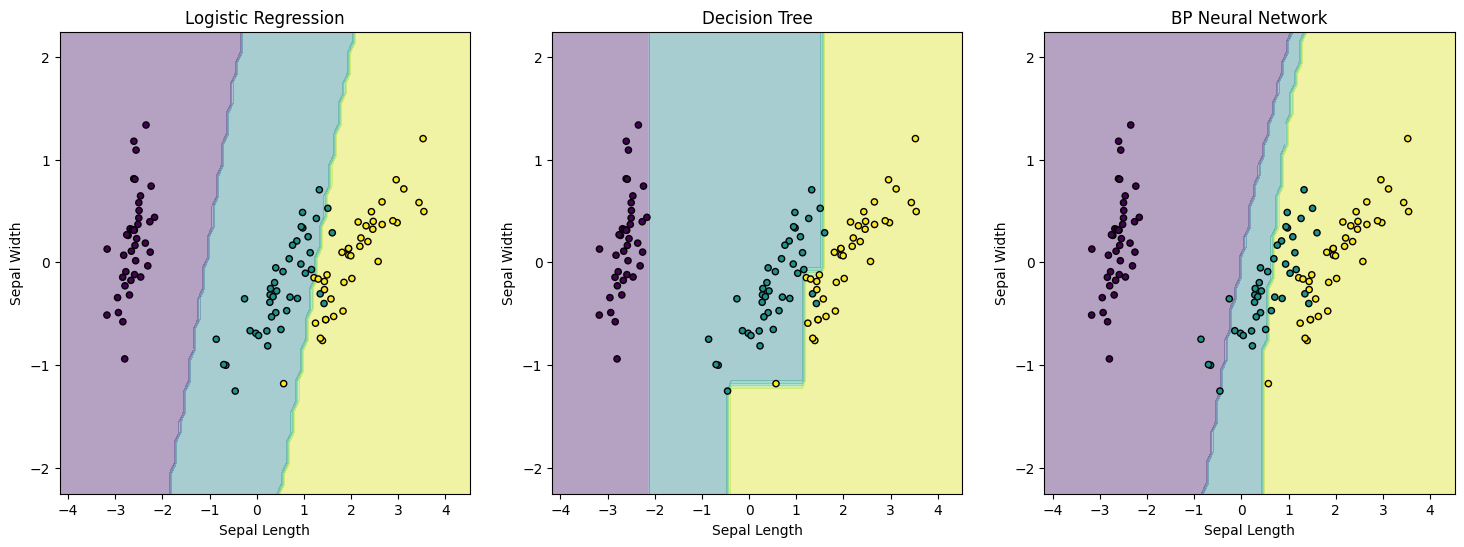

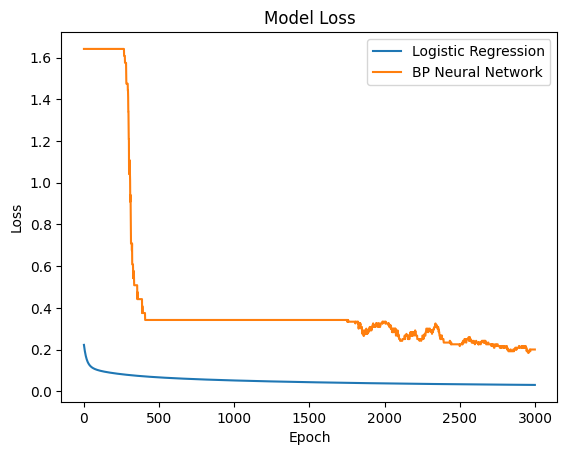

逻辑回归的准确度: 100.0%,决策树模型的准确度: 93.33333333333333%,BPNN的准确度: 76.66666666666667%


In [92]:

# 加载鸢尾花数据集
iris = load_iris()
X = iris.data
y = iris.target

LR = LogisticRegression(0.02,3000,3)
DT =DecisionTreeClassifier(2,3)
Bpnn=BPNN([2, 8, 3],0.02,3000,random_state=42)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# 使用PCA将数据降维到两个特征
pca = PCA(n_components=2)
X_train= pca.fit_transform(X_train)
X_test = pca.transform(X_test)

LR.fit(X_train, y_train)
DT.fit(X_train,y_train)
Bpnn.fit(X_train,y_train)


LR_predictions = LR.predict(X_test)
LR_accuracy = accuracy_score(y_test, np.array(LR_predictions))

DT_predictions=DT.predict(X_test)
DT_accuracy=accuracy_score(y_test,np.array(DT_predictions))

Bpnn_predictions=Bpnn.predict(X_test)
Bpnn_accuracy=accuracy_score(y_test,np.array(Bpnn_predictions))

print(classification_report(y_test, np.array(LR_predictions)))
print(classification_report(y_test, np.array(DT_predictions)))
print(classification_report(y_test, np.array(Bpnn_predictions)))

# 绘制分类边界的函数
def plot_decision_boundary(clf, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    Z = np.array(clf.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('y')
    

# 绘制分类边界
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plot_decision_boundary(LR, X_train, y_train, 'Logistic Regression')

plt.subplot(1, 3, 2)
plot_decision_boundary(DT, X_train, y_train, 'Decision Tree')

plt.subplot(1, 3, 3)
plot_decision_boundary(Bpnn, X_train, y_train, 'BP Neural Network')

plt.show()

plt.figure()
plt.plot(LR.losses,label='Logistic Regression')
plt.plot(Bpnn.losses,label="BP Neural Network")

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
print(f"逻辑回归的准确度: {LR_accuracy*100}%,决策树模型的准确度: {DT_accuracy*100}%,BPNN的准确度: {Bpnn_accuracy*100}%")